## 【ラストワンマイル問題】
### ◆ビジネス課題
#### 配達業務において、配達前に在宅有無を確認し、再配達を減らしたい
### ◆KPI
#### 再配達数を減少させること
### ◆利用可能なデータ
#### 電力スマートメーターのデータ
#### ※ただし、リアルタイムではなく、数ヶ月単位のデータ

## 0.準備

In [10]:
pip install chainer


The following command must be run outside of the IPython shell:

    $ pip install chainer

The Python package manager (pip) can only be used from outside of IPython.
Please reissue the `pip` command in a separate terminal or command prompt.

See the Python documentation for more informations on how to install packages:

    https://docs.python.org/3/installing/


In [11]:
import pandas as pd 
import numpy as np
import re
import copy
from datetime import datetime as dt
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import cross_validation
from sklearn import decomposition

%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt

（参考）本プロジェクトで使用するデータ

https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014

## 1.データ作成

In [12]:
#データの読み込み
dataset = pd.read_table("LD2011_2014.txt", sep =";")

/Users/yosuke/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,125,126,127,128,129,130,131,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,157,160,164,165,167,170,173,177,178,179,181,184,185,186,223,224,255,280,289,305,308,322,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,363,364,365,366,367,368,369,370) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
#データセットの中身を確認
dataset.head(5)

,Unnamed: 0,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
0,2011-01-01 00:15:00,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
1,2011-01-01 00:30:00,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2,2011-01-01 00:45:00,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
3,2011-01-01 01:00:00,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
4,2011-01-01 01:15:00,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0


In [14]:
# 行数と列数を確認
dataset.shape

(140256, 371)

In [15]:
# 小数点がカンマになっているため、データ型が一部文字列型になっている
# str型をfloat型にするために、数値の,を.に変換

dataset = dataset.replace(r",", ".",regex = True)  

# 列"Unnamed: 0"の名前を"time"に変更
dataset.rename(columns = {"Unnamed: 0": "time"}, inplace = True)

# time以外は全て小数点型にするので、timeを一度切り離して、float型に変更
data = dataset.drop("time", axis = 1)  # "time"のみ別扱いとする
data = data.astype("float")  # 数値をfloat型へ変換

In [16]:
# kWhに直す(UCIの説明書きにあるように4で割ってkWhに修正 )
data = data/4

# 元のデータが法人顧客データなので、500（これは適当）で割って個人宅レベルの電力量に変換
data = data/500

# 最後にtime列を作成
data["time"] = dataset["time"]

In [11]:
# 要約統計量を確認
data.describe()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
count,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,...,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000
mean,0.001985,0.010384,0.001459,0.041092,0.018620,0.070614,0.002261,0.095701,0.019988,0.021103,...,0.109107,18.803994,0.943714,1.470016,0.032707,0.004635,0.212131,0.047352,0.312626,4.361178
std,0.002992,0.006636,0.005507,0.029124,0.013231,0.049220,0.003243,0.060991,0.014907,0.016701,...,0.102417,19.345977,0.900743,1.366126,0.032504,0.005008,0.137169,0.040149,0.190328,4.597578
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.001422,0.000000,0.018293,0.007927,0.035714,0.000283,0.055556,0.006993,0.004839,...,0.002855,0.000000,0.000000,0.000000,0.006519,0.000000,0.000000,0.015025,0.041972,0.000000
50%,0.000635,0.012447,0.000869,0.043699,0.019512,0.078869,0.001413,0.111111,0.020105,0.020430,...,0.065667,12.050000,0.525316,1.068182,0.015645,0.003511,0.262950,0.038397,0.379032,0.000000
75%,0.001269,0.014936,0.000869,0.057927,0.027439,0.102679,0.002261,0.139731,0.028846,0.030645,...,0.201642,27.400000,1.656118,2.681818,0.054107,0.005851,0.313872,0.075960,0.437683,8.891892
max,0.024112,0.057610,0.075586,0.160569,0.075000,0.267857,0.022329,0.276094,0.078671,0.099462,...,0.426481,96.400000,3.875527,6.193182,0.167536,0.030135,0.569359,0.181135,0.774560,15.459459


In [12]:
# time列から　年、月、日、曜日、時を抜き出すために関数を用意

def get_year_from_time(x):
    time_date = dt.strptime(x, "%Y-%m-%d %H:%M:%S")
    return time_date.year
def get_month_from_time(x):
    time_date = dt.strptime(x, "%Y-%m-%d %H:%M:%S")
    return time_date.month
def get_day_from_time(x):
    time_date = dt.strptime(x, "%Y-%m-%d %H:%M:%S")
    return time_date.day
def get_weekday_from_time(x):
    time_date = dt.strptime(x, "%Y-%m-%d %H:%M:%S")
    return time_date.weekday()
def get_hour_from_time(x):
    time_date = dt.strptime(x, "%Y-%m-%d %H:%M:%S")
    return time_date.hour

In [13]:
# 上記で作成した関数をapplyで一括適用

data["year"] = data["time"].apply(get_year_from_time)
data["month"] = data["time"].apply(get_month_from_time)
data["day"] = data["time"].apply(get_day_from_time)
data["weekday"] = data["time"].apply(get_weekday_from_time)
data["hour"] = data["time"].apply(get_hour_from_time)

In [14]:
# 年ごとにデータを分割

data_2011 = data[data.year == 2011] #欠損データ多い
data_2012 = data[data.year == 2012]
data_2013 = data[data.year == 2013]
data_2014 = data[data.year == 2014] 
data_2015 = data[data.year == 2015] #1行のみ

# ⇒データは、最新の2014年のものを使用する。

## 2.データ整形

### データのグルーピング

In [15]:
# hour列から、時間帯(6h刻み)で分割するために関数を用意

def get_timezone_am1_from_hour(x):
    if x < 6:
        timezone = 1
    else:
        timezone = 0
    return timezone
def get_timezone_am2_from_hour(x):
    if x >= 6 and x < 12:
        timezone = 1
    else:
        timezone = 0
    return timezone
def get_timezone_pm1_from_hour(x):
    if x >= 12 and x < 18:
        timezone = 1
    else:
        timezone = 0
    return timezone
def get_timezone_pm2_from_hour(x):
    if x >= 18:
        timezone = 1
    else:
        timezone = 0
    return timezone

In [16]:
# 上記で作成した関数をapplyで一括適用

data_2014["am1"] = data_2014["hour"].apply(get_timezone_am1_from_hour)
data_2014["am2"] = data_2014["hour"].apply(get_timezone_am2_from_hour)
data_2014["pm1"] = data_2014["hour"].apply(get_timezone_pm1_from_hour)
data_2014["pm2"] = data_2014["hour"].apply(get_timezone_pm2_from_hour)

/Users/yosuke/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/yosuke/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/yosuke/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [17]:
# 時間帯と曜日でグルーピング
# グルーピングにあたっては、グループ内の平均値をとる

data_2014_grouping = data_2014.groupby(["weekday", "am1", "am2", "pm1", "pm2"]).mean()
data_2014_grouping.head(28)

MT_001    MT_002    MT_003    MT_004    MT_005  \
weekday am1 am2 pm1 pm2                                                     
0       0   0   0   1    0.001867  0.014596  0.000905  0.084521  0.036182   
                1   0    0.001655  0.013822  0.000760  0.051773  0.025066   
            1   0   0    0.002272  0.014792  0.000833  0.048952  0.021084   
        1   0   0   0    0.001930  0.010518  0.000851  0.051397  0.023651   
1       0   0   0   1    0.001946  0.014472  0.000905  0.085979  0.035491   
                1   0    0.002059  0.013568  0.000833  0.051148  0.023950   
            1   0   0    0.002591  0.014516  0.000833  0.048744  0.022350   
        1   0   0   0    0.002007  0.010535  0.000869  0.051795  0.024968   
2       0   0   0   1    0.002088  0.014638  0.000923  0.084224  0.035477   
                1   0    0.001956  0.013759  0.000835  0.050889  0.023433   
            1   0   0    0.002513  0.014575  0.000817  0.049309  0.021974   
        1   0   0   0    0.002098  0.010348  0.000835  0.052496  0.024625   
3       0   0   0   1    0.002182  0.014260  0.000852  0.085506  0.035392   
                1   0    0.002081  0.013359  0.000817  0.052227  0.022935   
            1   0   0    0.002375  0.014676  0.000870  0.049325  0.022300   
        1   0   0   0    0.002060  0.010528  0.000852  0.051797  0.024786   
4       0   0   0   1    0.001927  0.014212  0.000996  0.084526  0.033838   
                1   0    0.002036  0.013873  0.000815  0.053738  0.023207   
            1   0   0    0.002841  0.014548  0.000724  0.050096  0.022798   
        1   0   0   0    0.002529  0.010213  0.000868  0.052230  0.024807   
5       0   0   0   1    0.001812  0.014197  0.000869  0.082848  0.032648   
                1   0    0.001522  0.014741  0.000887  0.067416  0.023226   
            1   0   0    0.001637  0.014251  0.001032  0.054246  0.021208   
        1   0   0   0    0.001948  0.010645  0.000905  0.053437  0.024722   
6       0   0   0   1    0.001812  0.014456  0.000887  0.076811  0.030611   
                1   0    0.001503  0.014751  0.000851  0.060101  0.021602   
            1   0   0    0.001615  0.013981  0.000869  0.054071  0.020361   
        1   0   0   0    0.001942  0.010671  0.000643  0.054624  0.025311   

                           MT_006    MT_007    MT_008    MT_009    MT_010  \
weekday am1 am2 pm1 pm2                                                     
0       0   0   0   1    0.125801  0.003768  0.153512  0.034228  0.033823   
                1   0    0.096006  0.002448  0.129905  0.024094  0.038426   
            1   0   0    0.082399  0.002047  0.115807  0.024913  0.025632   
        1   0   0   0    0.065322  0.002368  0.096505  0.021993  0.022831   
1       0   0   0   1    0.129861  0.003806  0.156514  0.034346  0.033746   
                1   0    0.101058  0.002657  0.136675  0.023639  0.035295   
            1   0   0    0.086135  0.002641  0.118997  0.025549  0.022913   
        1   0   0   0    0.068231  0.003064  0.100337  0.022189  0.023038   
2       0   0   0   1    0.127990  0.003929  0.153342  0.034076  0.034578   
                1   0    0.095711  0.002408  0.133341  0.023267  0.036407   
            1   0   0    0.083971  0.002684  0.119846  0.025626  0.022909   
        1   0   0   0    0.067706  0.003051  0.098666  0.022632  0.023432   
3       0   0   0   1    0.125732  0.003989  0.152613  0.033304  0.033928   
                1   0    0.098732  0.002821  0.131842  0.023431  0.035387   
            1   0   0    0.088131  0.002900  0.119626  0.025818  0.022963   
        1   0   0   0    0.069590  0.003194  0.100402  0.022350  0.023638   
4       0   0   0   1    0.122867  0.003825  0.154017  0.032719  0.033462   
                1   0    0.099583  0.002872  0.139798  0.024072  0.035856   
            1   0   0    0.087143  0.002863  0.124562  0.025392  0.024185   
        1   0   0   0    0.066942  0.003187  0.100611  0.022175  0.023584   
5       0   0   0   1 

In [18]:
# 不要行削除

data_2014_grouping = data_2014_grouping.drop("year", axis = 1)
data_2014_grouping = data_2014_grouping.drop("month", axis = 1)
data_2014_grouping = data_2014_grouping.drop("day", axis = 1)
data_2014_grouping = data_2014_grouping.drop("hour", axis = 1)

data_2014_grouping.head(28)

MT_001    MT_002    MT_003    MT_004    MT_005  \
weekday am1 am2 pm1 pm2                                                     
0       0   0   0   1    0.001867  0.014596  0.000905  0.084521  0.036182   
                1   0    0.001655  0.013822  0.000760  0.051773  0.025066   
            1   0   0    0.002272  0.014792  0.000833  0.048952  0.021084   
        1   0   0   0    0.001930  0.010518  0.000851  0.051397  0.023651   
1       0   0   0   1    0.001946  0.014472  0.000905  0.085979  0.035491   
                1   0    0.002059  0.013568  0.000833  0.051148  0.023950   
            1   0   0    0.002591  0.014516  0.000833  0.048744  0.022350   
        1   0   0   0    0.002007  0.010535  0.000869  0.051795  0.024968   
2       0   0   0   1    0.002088  0.014638  0.000923  0.084224  0.035477   
                1   0    0.001956  0.013759  0.000835  0.050889  0.023433   
            1   0   0    0.002513  0.014575  0.000817  0.049309  0.021974   
        1   0   0   0    0.002098  0.010348  0.000835  0.052496  0.024625   
3       0   0   0   1    0.002182  0.014260  0.000852  0.085506  0.035392   
                1   0    0.002081  0.013359  0.000817  0.052227  0.022935   
            1   0   0    0.002375  0.014676  0.000870  0.049325  0.022300   
        1   0   0   0    0.002060  0.010528  0.000852  0.051797  0.024786   
4       0   0   0   1    0.001927  0.014212  0.000996  0.084526  0.033838   
                1   0    0.002036  0.013873  0.000815  0.053738  0.023207   
            1   0   0    0.002841  0.014548  0.000724  0.050096  0.022798   
        1   0   0   0    0.002529  0.010213  0.000868  0.052230  0.024807   
5       0   0   0   1    0.001812  0.014197  0.000869  0.082848  0.032648   
                1   0    0.001522  0.014741  0.000887  0.067416  0.023226   
            1   0   0    0.001637  0.014251  0.001032  0.054246  0.021208   
        1   0   0   0    0.001948  0.010645  0.000905  0.053437  0.024722   
6       0   0   0   1    0.001812  0.014456  0.000887  0.076811  0.030611   
                1   0    0.001503  0.014751  0.000851  0.060101  0.021602   
            1   0   0    0.001615  0.013981  0.000869  0.054071  0.020361   
        1   0   0   0    0.001942  0.010671  0.000643  0.054624  0.025311   

                           MT_006    MT_007    MT_008    MT_009    MT_010  \
weekday am1 am2 pm1 pm2                                                     
0       0   0   0   1    0.125801  0.003768  0.153512  0.034228  0.033823   
                1   0    0.096006  0.002448  0.129905  0.024094  0.038426   
            1   0   0    0.082399  0.002047  0.115807  0.024913  0.025632   
        1   0   0   0    0.065322  0.002368  0.096505  0.021993  0.022831   
1       0   0   0   1    0.129861  0.003806  0.156514  0.034346  0.033746   
                1   0    0.101058  0.002657  0.136675  0.023639  0.035295   
            1   0   0    0.086135  0.002641  0.118997  0.025549  0.022913   
        1   0   0   0    0.068231  0.003064  0.100337  0.022189  0.023038   
2       0   0   0   1    0.127990  0.003929  0.153342  0.034076  0.034578   
                1   0    0.095711  0.002408  0.133341  0.023267  0.036407   
            1   0   0    0.083971  0.002684  0.119846  0.025626  0.022909   
        1   0   0   0    0.067706  0.003051  0.098666  0.022632  0.023432   
3       0   0   0   1    0.125732  0.003989  0.152613  0.033304  0.033928   
                1   0    0.098732  0.002821  0.131842  0.023431  0.035387   
            1   0   0    0.088131  0.002900  0.119626  0.025818  0.022963   
        1   0   0   0    0.069590  0.003194  0.100402  0.022350  0.023638   
4       0   0   0   1    0.122867  0.003825  0.154017  0.032719  0.033462   
                1   0    0.099583  0.002872  0.139798  0.024072  0.035856   
            1   0   0    0.087143  0.002863  0.124562  0.025392  0.024185   
        1   0   0   0    0.066942  0.003187  0.100611  0.022175  0.023584   
5       0   0   0   1 

### 電力消費量から在宅有無を推定

In [20]:
# 在/不在の判断を電力消費量から推定する
# 電力消費量が平均値以下なら不在(=0)、平均値以上なら在宅(=1)とする

for col in data_2014_grouping.columns:
    data_2014_grouping.loc[data_2014_grouping.loc[:, col] > data_2014_grouping.loc[:, col].mean(), col] = 1
    data_2014_grouping.loc[data_2014_grouping.loc[:, col] <= data_2014_grouping.loc[:, col].mean(), col] = 0
data_2014_grouping.head(28)

MT_001  MT_002  MT_003  MT_004  MT_005  MT_006  \
weekday am1 am2 pm1 pm2                                                   
0       0   0   0   1       0.0     1.0     1.0     1.0     1.0     1.0   
                1   0       0.0     1.0     0.0     0.0     0.0     1.0   
            1   0   0       1.0     1.0     0.0     0.0     0.0     0.0   
        1   0   0   0       0.0     0.0     0.0     0.0     0.0     0.0   
1       0   0   0   1       0.0     1.0     1.0     1.0     1.0     1.0   
                1   0       1.0     1.0     0.0     0.0     0.0     1.0   
            1   0   0       1.0     1.0     0.0     0.0     0.0     0.0   
        1   0   0   0       0.0     0.0     1.0     0.0     0.0     0.0   
2       0   0   0   1       1.0     1.0     1.0     1.0     1.0     1.0   
                1   0       0.0     1.0     0.0     0.0     0.0     1.0   
            1   0   0       1.0     1.0     0.0     0.0     0.0     0.0   
        1   0   0   0       1.0     0.0     0.0     0.0     0.0     0.0   
3       0   0   0   1       1.0     1.0     0.0     1.0     1.0     1.0   
                1   0       1.0     1.0     0.0     0.0     0.0     1.0   
            1   0   0       1.0     1.0     1.0     0.0     0.0     0.0   
        1   0   0   0       1.0     0.0     0.0     0.0     0.0     0.0   
4       0   0   0   1       0.0     1.0     1.0     1.0     1.0     1.0   
                1   0       1.0     1.0     0.0     0.0     0.0     1.0   
            1   0   0       1.0     1.0     0.0     0.0     0.0     0.0   
        1   0   0   0       1.0     0.0     1.0     0.0     0.0     0.0   
5       0   0   0   1       0.0     1.0     1.0     1.0     1.0     1.0   
                1   0       0.0     1.0     1.0     1.0     0.0     1.0   
            1   0   0       0.0     1.0     1.0     0.0     0.0     0.0   
        1   0   0   0       0.0     0.0     1.0     0.0     0.0     0.0   
6       0   0   0   1       0.0     1.0     1.0     1.0     1.0     1.0   
                1   0       0.0     1.0     0.0     0.0     0.0     0.0   
            1   0   0       0.0     1.0     1.0     0.0     0.0     0.0   
        1   0   0   0       0.0     0.0     0.0     0.0     0.0     0.0   

                         MT_007  MT_008  MT_009  MT_010   ...    MT_361  \
weekday am1 am2 pm1 pm2                                   ...             
0       0   0   0   1       1.0     1.0     1.0     1.0   ...       1.0   
                1   0       0.0     1.0     0.0     1.0   ...       1.0   
            1   0   0       0.0     0.0     0.0     0.0   ...       0.0   
        1   0   0   0       0.0     0.0     0.0     0.0   ...       0.0   
1       0   0   0   1       1.0     1.0     1.0     1.0   ...       1.0   
                1   0       0.0     1.0     0.0     1.0   ...       1.0   
            1   0   0       0.0     0.0     1.0     0.0   ...       0.0   
        1   0   0   0       1.0     0.0     0.0     0.0   ...       0.0   
2       0   0   0   1       1.0     1.0     1.0     1.0   ...       1.0   
                1   0       0.0     1.0     0.0     1.0   ...       1.0   
            1   0   0       0.0     0.0     1.0     0.0   ...       0.0   
        1   0   0   0       1.0     0.0     0.0     0.0   ...       0.0   
3       0   0   0   1       1.0     1.0     1.0     1.0   ...       1.0   
                1   0       0.0     1.0     0.0     1.0   ...       1.0   
            1   0   0       0.0     0.0     1.0     0.0   ...       0.0   
        1   0   0   0       1.0     0.0     0.0     0.0   ...       0.0   
4       0   0   0   1       1.0     1.0     1.0     1.0   ...       1.0   
                1   0       0.0     1.0     0.0     1.0   ...       1.0   
            1   0   0       0.0     0.0     0.0     0.0   ...       0.0   
        1   0   0   0       1.0     0.0     0.0     0.0   ...       0.0   
5       0   0   0   1       1.0     1.0     1.0     1.0   ...       1.0   
                1   0       0.0     1.0     0.0  

## 3.データの2次元圧縮

### 主成分分析(PCA)

#### PCA(線形アルゴリズム)とは、データセットの特徴量を回転させることで行う分析手法
####  ①最も分散が大きい方向をみつけ、その方向の軸を第1成分とする
####  ②第1成分と直行する軸のうち最も情報を持つ軸を探し第2成分とする
####  ③これを繰り返す

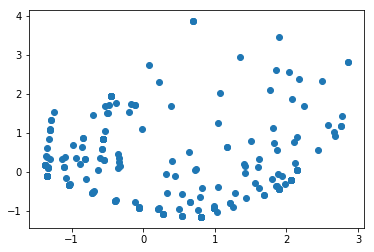

In [21]:
data_2014_grouping_T_PCA = data_2014_grouping.T
pca = PCA(n_components=2)
data_2014_grouping_T_PCA_reduced = pca.fit_transform(data_2014_grouping_T_PCA)
#################### 可視化 ####################
plt.scatter(data_2014_grouping_T_PCA_reduced[:, 0], data_2014_grouping_T_PCA_reduced[:, 1])

### 非負値行列分解（NMF）

#### NMFとは、特徴量を抽出することを目的とする教師なし学習手法
#### 係数と成分が非負（特徴量が非負）のデータにしか使えない
#### 複数の独立した発生源からのデータを重ね合わせたデータに有効であり、合成データをうまく分離できる

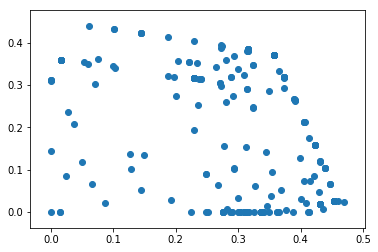

In [22]:
data_2014_grouping_T_NMF = data_2014_grouping.T
nmf = NMF(n_components=2)
data_2014_grouping_T_NMF_reduced = nmf.fit_transform(data_2014_grouping_T_NMF)
#################### 可視化 ####################
plt.scatter(data_2014_grouping_T_NMF_reduced[:, 0], data_2014_grouping_T_NMF_reduced[:, 1])

### t-SNE法

#### t-SNE法の特徴は、2点間の「近さ」を確率分布で表現すること。
#### 高次元データの次元を圧縮するアルゴリズムであり、特に高次元データを可視化する際に有用。

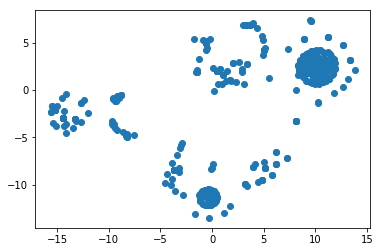

In [56]:
data_2014_grouping_T_TSNE = data_2014_grouping.T
data_2014_grouping_T_TSNE_reduced = TSNE(n_components=2, random_state=0).fit_transform(data_2014_grouping_T_TSNE)
#################### 可視化 ####################
plt.scatter(data_2014_grouping_T_TSNE_reduced[:, 0], data_2014_grouping_T_TSNE_reduced[:, 1])

### 次元圧縮の結論
#### 次元圧縮の目的は、K-Meansで分類するためのデータの作成である。
#### そのため、可視化して最も分類出来そうな＜t-SNE＞ を採用する。

## 4.データ分類

### t-SNE法により次元削減したデータをK-Means法で分類

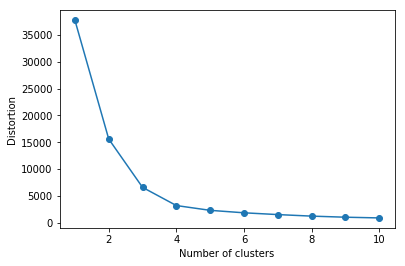

In [42]:
# エルボー法によりクラスタ数を算出
distortions = []

for i  in range(1,11):
    km = KMeans(n_clusters=i,
                init='k-means++',
                n_init=10,
                max_iter=300,
                random_state=0)
    km.fit(data_2014_grouping_T_TSNE_reduced)
    distortions.append(km.inertia_)

plt.plot(range(1,11),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

# クラスター数は、4とする

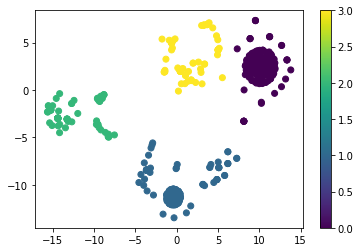

In [43]:
km = KMeans(n_clusters= 4, random_state=0).fit(data_2014_grouping_T_TSNE_reduced)

plt.scatter(data_2014_grouping_T_TSNE_reduced[:, 0], data_2014_grouping_T_TSNE_reduced[:, 1], c=km.predict(data_2014_grouping_T_TSNE_reduced))
plt.colorbar()

#### t-SNE法により次元削減したデータをK-Means法で4つに分類可能

## 5.考察

In [53]:
# 次元圧縮前のデータに、クラスター分類を追加

km_p = km.predict(data_2014_grouping_T_TSNE_reduced)

data_2014_grouping_T_TSNE['cluster'] = km_p
data_2014_grouping_T_TSNE.head()

weekday    0                   1                   2        ...      4    5  \
am1        0              1    0              1    0        ...      1    0   
am2        0         1    0    0         1    0    0        ...      0    0   
pm1        0    1    0    0    0    1    0    0    0    1   ...      0    0   
pm2        1    0    0    0    1    0    0    0    1    0   ...      0    1   
MT_001   0.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0  1.0  0.0   ...    1.0  0.0   
MT_002   1.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0   ...    0.0  1.0   
MT_003   1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0   ...    1.0  1.0   
MT_004   1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0   ...    0.0  1.0   
MT_005   1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0   ...    0.0  1.0   

weekday                   6                cluster  
am1                  1    0              1          
am2             1    0    0         1    0          
pm1        1    0    0    0    1    0    0          
pm2        0    0    0    1    0    0    0          
MT_001   0.0  0.0  0.0  0.0  0.0  0.0  0.0       3  
MT_002   1.0  1.0  0.0  1.0  1.0  1.0  0.0       0  
MT_003   1.0  1.0  1.0  1.0  0.0  1.0  0.0       2  
MT_004   1.0  0.0  0.0  1.0  0.0  0.0  0.0       2  
MT_005   0.0  0.0  0.0  1.0  0.0  0.0  0.0       2  

[5 rows x 29 columns]

In [54]:
# クラスターごとに平均値をグルーピング

data_2014_grouping_T_TSNE_grouped = data_2014_grouping_T_TSNE.groupby(["cluster"]).mean().T
data_2014_grouping_T_TSNE_grouped.head()

cluster                         0         1         2         3
weekday am1 am2 pm1 pm2                                        
0       0   0   0   1    1.000000  0.981132  0.797297  0.647887
                1   0    1.000000  0.952830  0.108108  0.971831
            1   0   0    0.957983  0.018868  0.148649  0.929577
        1   0   0   0    0.000000  0.000000  0.283784  0.000000
1       0   0   0   1    0.991597  0.981132  0.770270  0.633803

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a133f05f8>,
      dtype=object)

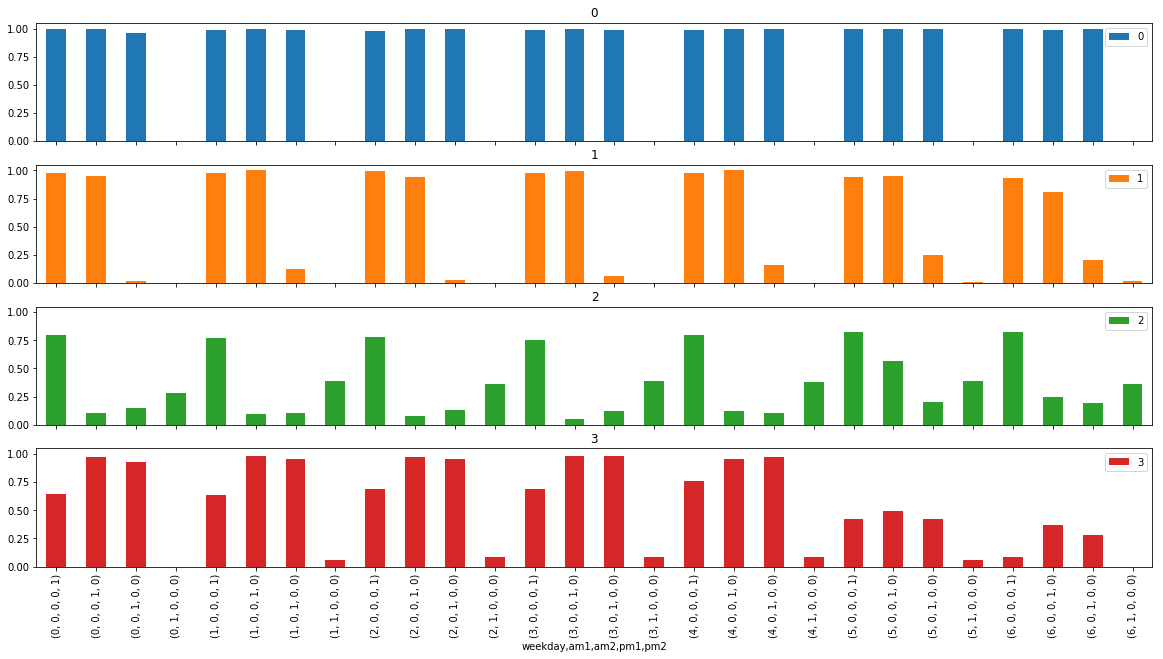

In [55]:
data_2014_grouping_T_TSNE_grouped.plot.bar(subplots = True, 
                                           sharey = True, 
                                           #layout = (3, 1), 
                                           figsize = (20, 10), 
                                           grid = False,
                                          )

### クラスター1
#### 平日・休日関係なく、夜以外、電気ついている。
#### ⇒ペルソナ：毎日稼働している会社

### クラスター2
#### 平日・休日関係なく、午前中に電気ついている。
#### ⇒ペルソナ：午後に働くようなシフトの人

### クラスター3
#### 朝晩、電気ついている。
#### 休日の方がいる可能性高い。
#### ⇒ペルソナ：シフト制でない企業に勤めている人

### クラスター4
#### 夜以外、電気ついている。
#### 平日の方がいる可能性が高い。
#### ⇒ペルソナ：平日稼働している会社

## 6.結論

#### 電力データを利用することで、曜日・時間帯により生活スタイルは4つに分類可能。
#### 配達先の生活スタイルをいずれかに分類することで、事前に特定の曜日・時間帯における在宅有無を推定し、再配達を減らすことが出来る。